## I Had tried to make whole end to end project. Also made Webapp using Flask.
## Please dont forgot to watch video which i have provided. Video contains the 
## demonstration of webapp. 

Table of Contents

 1- Importing All required libraries

 2- Playing with Data little Bit

 3- Data preprocessing

 4- CNN model from Scratch

 5- VGG16 network

 6- VGG19 network

 7- InceptionV3 network
 
 8- Testing our model
  

In [101]:
import cv2
import pandas as pd
import numpy as np
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
import scipy
from tqdm import tqdm
import itertools
from sklearn.metrics import confusion_matrix

# !pip install glob3
from glob import glob


from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, merge , Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.imagenet_utils import preprocess_input as zero_mean
from keras.models import Model
from keras.models import Sequential

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Train_dir = "/content/drive/My Drive/Monkey classfier/training"  
Test_dir = "/content/drive/My Drive/Monkey classfier/validation"

In [ ]:
# Useful for getting the number of classes
folder_train = glob("/content/drive/My Drive/Monkey classfier/training/*")
folder_test = glob("/content/drive/My Drive/Monkey classfier/training/*")
print(folder_train)
print(folder_test)

['/content/drive/My Drive/Monkey classfier/training/n9', '/content/drive/My Drive/Monkey classfier/training/n5', '/content/drive/My Drive/Monkey classfier/training/n7', '/content/drive/My Drive/Monkey classfier/training/n1', '/content/drive/My Drive/Monkey classfier/training/n8', '/content/drive/My Drive/Monkey classfier/training/n0', '/content/drive/My Drive/Monkey classfier/training/n2', '/content/drive/My Drive/Monkey classfier/training/n3', '/content/drive/My Drive/Monkey classfier/training/n4', '/content/drive/My Drive/Monkey classfier/training/n6']
['/content/drive/My Drive/Monkey classfier/training/n9', '/content/drive/My Drive/Monkey classfier/training/n5', '/content/drive/My Drive/Monkey classfier/training/n7', '/content/drive/My Drive/Monkey classfier/training/n1', '/content/drive/My Drive/Monkey classfier/training/n8', '/content/drive/My Drive/Monkey classfier/training/n0', '/content/drive/My Drive/Monkey classfier/training/n2', '/content/drive/My Drive/Monkey classfier/trai

#Playing with Data little bit

I am Splitting my data into feature and labels.
It is done for just making confusion matrix and Bar chart

In [ ]:
def get_data(folder):
  X = []
  y = []
  for folderName in os.listdir(folder):
      if folderName in ['n0']:
            label = 0
      elif folderName in ['n1']:
            label = 1
      elif folderName in ['n2']:
            label = 2
      elif folderName in ['n3']:
            label = 3
      elif folderName in ['n4']:
            label = 4
      elif folderName in ['n5']:
            label = 5
      elif folderName in ['n6']:
            label = 6
      elif folderName in ['n7']:
            label = 7
      elif folderName in ['n8']:
            label = 8
      elif folderName in ['n9']:
            label = 9
      for image_filename in tqdm(os.listdir(folder + '/' + folderName)):
                img_file = cv2.imread(folder + '/' + folderName + '/' + image_filename)
                if img_file is not None:
                    
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
  X = np.asarray(X)
  y = np.asarray(y)
  return X,y
          
X_train, y_train = get_data(Train_dir)
X_test, y_test= get_data(Test_dir)

100%|██████████| 26/26 [00:00<00:00, 96.23it/s]


In [ ]:
print("Our data have {0} training images and {1} validation images".format(X_train.shape[0], X_test.shape[0]))
print("There are total {0} different species(labels) of monkeys".format(len(folder_train)))

Our data have 1064 training images and 272 validation images
There are total 10 different species(labels) of monkeys


Distribution of Training Data per label

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


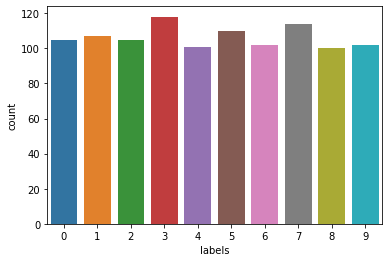

In [92]:
dict_characters = {0: 'mantled_howler', 1: 'patas_monkey',2:'bald_uakari',3:'japanese_macaque',4:'pygmy_marmoset',5:'white_headed_capuchin',6:'silvery_marmoset',7:'common_squirrel_monkey',8:'black_headed_night_monkey',9:'nilgiri_langur'}
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
sns.countplot(lab)

The distribution of all the classes is almost balanced in our training data.

In [96]:
#Assigning all the label name in varibale labels in form of list.
# This labels variable i am going to use only in confusion matrix
labels = list(dict_characters.values())

In [111]:
# Confusion matrix function to visualize that how much correct prediction our model makes
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.figure(figsize = (16,9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data Preprocessing

In [ ]:
Img_Size = [224,224]

In [ ]:
#this function is used to see how data augmentation works
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
#We have small dataset so we will generate some replicas of original image to increase our dataset by ImageDataGenerator function

train_data_generator = ImageDataGenerator(
    rescale = 1./255,   #normalizing the image 
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    )

# Flow training images in batches of 32 using train_datagen generator
train_data = train_data_generator.flow_from_directory(
    Train_dir,
    target_size = (224,224),      # All images will be resized to 224x224
    batch_size = 32,              #We will compute 32 images at one go
    class_mode = 'categorical',   #Since we have multi class so using "categorical" class mode.
    shuffle = True,               #Shuffling the data randomly
    seed = 2)                   



Found 1064 images belonging to 10 classes.


In [ ]:
# validation data generator
val_data_generator = ImageDataGenerator(rescale = 1./255) # no augmentation is used on validation because it is used for testing purpose.

# Flow training images in batches of 32 using train_datagen generator
val_data = val_data_generator.flow_from_directory(      #flow from directory is used because of multiple images we want to augment
    Test_dir,
    target_size = (224, 224),                         # All images will be resized to 224x224
    batch_size = 32,                                  #We will compute 32 images at one go
    shuffle = True,
    seed = 2,                                
    class_mode = 'categorical')   

Found 272 images belonging to 10 classes.


Example of How Data Augmentation internally works

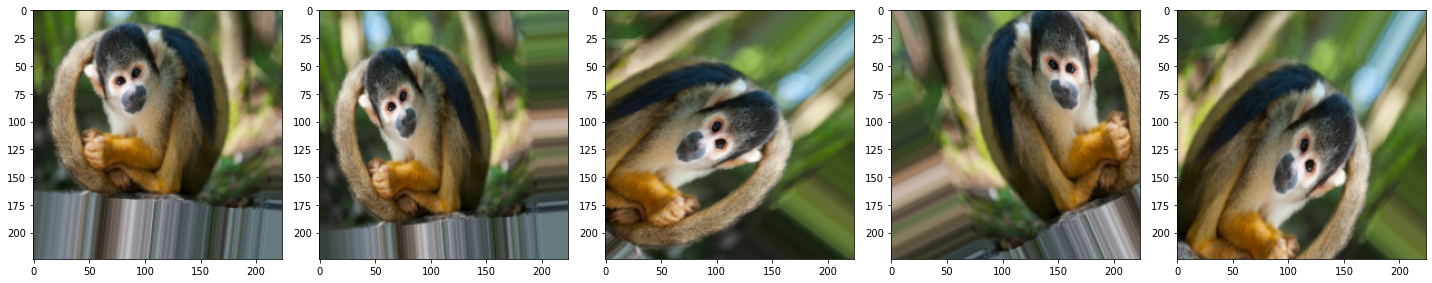

In [ ]:
#It is generating the replica of same image in different angles and size.
images = [train_data[1][0][0] for i in range(5)]
plotImages(images)
 

In [ ]:
train_data.class_indices

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

# CNN model from scratch

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), input_shape=(224,224, 3)))  #Convolution layer with 32 filters and (3x3) Kernel Size
model_cnn.add(Activation('relu'))                            # Applied Activation Function relu to make data non linear.  
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))                # Max Pooling Layer (of 2x2)

model_cnn.add(Conv2D(32, (3, 3)))                            #Convolution layer with 32 filters and (3x3) Kernel Size
model_cnn.add(Activation('relu'))                            # Applied Activation Function relu to make data non linear.
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))                # Max Pooling Layer (of 2x2) 
                                                           
model_cnn.add(Conv2D(64, (3, 3), padding='same'))        #In this Layer padding is done to keep our matrix size same as previous output matrix
model_cnn.add(Activation('relu'))
model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))                              #Dropout of overall 25% weights of network to get rid of overfitting

model_cnn.add(Flatten())                                  #Flattening the data from matrix to vector form
model_cnn.add(Dense(512))                                 #Now data is passed through fully connected layer of 512 hidden neurons.
model_cnn.add(Activation('relu'))                         
model_cnn.add(Dropout(0.5)) 
model_cnn.add(Dense(10))                                  #Forwarding data to Fully connected layer of 10 neurons 
model_cnn.add(Activation('softmax'))                      #Softmax function is applied to data which gives 10 output(Because we have 10 class)
                                                          #And all the output from 10 neurons are in probability forms and by summing up we 
                                                          # get 1. And Those who have high probability is our predicted class. 

In [ ]:
model_cnn.compile(optimizer='adam',                  #Using Adam optimizer as it will solve the problems of local minima convergence.
              loss='categorical_crossentropy',       
              metrics=['acc'])
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 64)        1

In [ ]:
#Here Trainable Params is 22,222,378. Which is the total weigts in our network

We will now fit our data in the model we have build

In [ ]:
t = time.time()
hist = model_cnn.fit_generator(
    generator = train_data,       #Training data internally takes X_train and Y_train 
    epochs = 40,                  #Keeping epochs of 40
    validation_data = val_data)   #This val_data internally takes the X_test and Y_test.(No need to mention them explicitly )
print("Training time: %s min" %((time.time()-t)/60))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
34/34 [==============================] - 38s 1s/step - loss: 2.3736 - acc: 0.1147 - val_loss: 2.2960 - val_acc: 0.2243
Epoch 2/40
34/34 [==============================] - 39s 1s/step - loss: 2.2911 - acc: 0.1410 - val_loss: 2.2690 - val_acc: 0.0919
Epoch 3/40
34/34 [==============================] - 40s 1s/step - loss: 2.2508 - acc: 0.1598 - val_loss: 2.1889 - val_acc: 0.1728
Epoch 4/40
34/34 [==============================] - 39s 1s/step - loss: 2.1845 - acc: 0.1945 - val_loss: 2.0327 - val_acc: 0.2463
Epoch 5/40
34/34 [==============================] - 40s 1s/step - loss: 2.0078 - acc: 0.2697 - val_loss: 1.8548 - val_acc: 0.3346
Epoch 6/40
34/34 [==============================] - 39s 1s/step - loss: 1.8590 - acc: 0.3092 - val_loss: 1.7805 - val_acc: 0.3640
Epoch 7/40
34/34 [==============================] - 39s 1s/step - loss: 1.7590 - acc: 0.3477 - val_loss: 1.5990 - val_acc: 0.4191
Epoch 8/40
34/

Visualizing our results

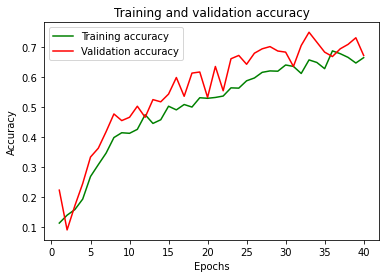

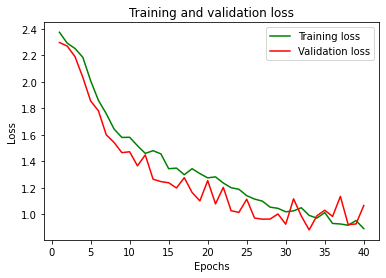

In [ ]:
accuracy = hist.history["acc"]
val_acc = hist.history['val_acc']
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
epochs = range(1,len(accuracy)+1)

plt.title("Training and validation accuracy")
plt.plot(epochs, accuracy, "green", label = "Training accuracy")
plt.plot(epochs, val_acc, "red", label = "Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.title("Training and validation loss")
plt.plot(epochs, loss, "green", label = "Training loss")
plt.plot(epochs, val_loss, "red", label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [98]:
y_pred_cnn = model_cnn.predict(val_data)   #this line of code will give result in form of probabilities with 10 results of each image
y_pred_cnn = np.argmax(y_pred_cnn , axis = 1)  #this line will choose maximim probability among 10 results and will print it. 
print(y_pred_cnn)

[4 1 7 6 0 8 6 0 8 1 8 2 4 1 5 8 2 3 0 0 1 0 1 9 0 4 4 7 2 8 8 4 8 6 9 8 9
 8 9 9 9 8 9 5 8 4 9 1 9 3 4 7 8 1 1 4 7 3 1 3 1 4 7 0 9 9 8 1 1 9 1 1 0 0
 6 5 2 0 4 1 9 4 0 5 4 1 9 8 9 9 4 1 1 4 7 3 6 1 4 0 1 5 0 3 3 9 8 4 0 1 5
 2 6 5 4 8 8 3 9 3 6 1 9 4 0 2 5 1 1 3 1 4 8 1 4 0 0 5 3 3 0 4 9 6 1 9 9 4
 8 2 2 4 4 1 8 2 4 2 9 2 1 5 5 1 9 6 3 3 2 2 6 7 4 5 7 4 9 9 7 2 1 4 9 0 3
 9 9 8 0 9 5 2 8 1 1 2 4 1 7 2 1 6 1 9 8 1 4 4 8 8 3 2 8 4 2 1 0 9 9 9 7 1
 2 0 9 9 5 0 2 0 1 4 4 1 4 4 2 8 8 1 0 4 4 1 2 2 2 1 1 9 4 1 9 9 6 3 2 3 6
 3 5 7 2 8 9 1 1 0 3 4 3 3]


In [97]:
score = model_cnn.evaluate(val_data, verbose=1)
print(score)
print('\nKeras CNN - accuracy:', score[1], '\n')

9/9 [==============================] - 6s 697ms/step - loss: 1.0654 - acc: 0.6728
[1.0654263496398926, 0.6727941036224365]

Keras CNN - accuracy: 0.6727941036224365 



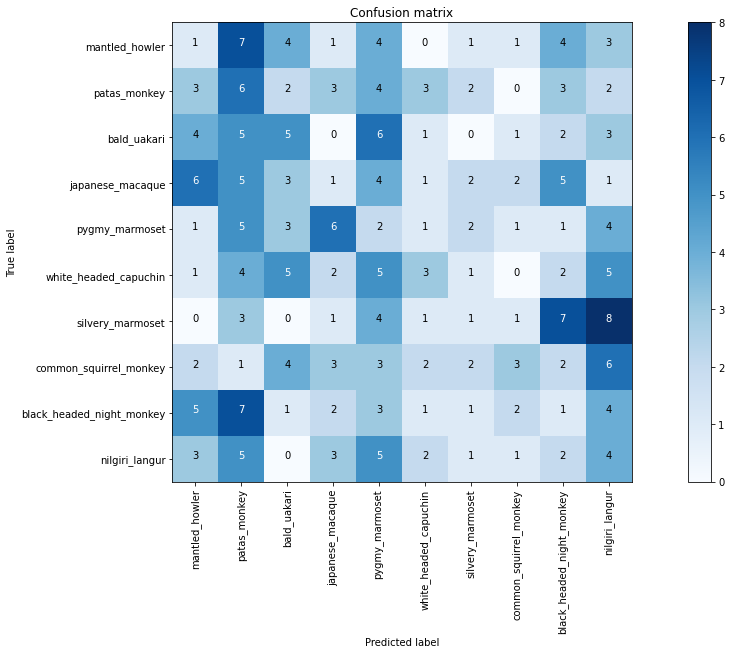

In [112]:
confusion_mtx = confusion_matrix(y_test, y_pred_cnn)
plot_confusion_matrix(confusion_mtx, classes = labels)
plt.show()


In [113]:
#Saving the model
model_cnn.save("/content/drive/My Drive/Monkey classfier/model_cnn.h5")  

### Next I will use all the pretrained models

#VGG16

FINE TUNING BY UNFREEZING THE LAST BLOCK OF VGG16

In [114]:
# We now ignore the top layer(3 FC layers) from the original VGG16 model, and grab the max pooling layer
# that follows the last convolution block to use it a input to a new fully connected classifier.                                                                                     

vgg = VGG16(input_shape = Img_Size + [3], weights = "imagenet", include_top = False)  
                                                                                     

58892288/58889256 [==============================] - 0s 0us/step


In [115]:
# Since the model is already trained with certain weights, we dont want to change it. Let it be the same
for layer in vgg.layers:    
  layer.trainable = False

In [119]:

last_layer = vgg.get_layer('block5_pool').output  #Till 5th max pooling layer i kept everythig same and following layers is simply dropped
x= Flatten(name='flatten')(last_layer) # flatten the output of the pooling layer and pass it to the next Fully Connected layer
x = Dense(512, activation='relu', name='fc1')(x) # fc1
x = Dense(512, activation='relu', name='fc2')(x) # fc2
out = Dense(units=10, activation='softmax', name='output')(x) # softamx output (We have 10 classes)


In [120]:
model_vgg16 = Model(inputs = vgg.input , outputs = out)   #Giving input data and the respective classes of those inputs.
model_vgg16.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [121]:
model_vgg16.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [123]:
#Training our data
t = time.time()
history = model_vgg16.fit_generator(
    generator = train_data,
    epochs = 40,
    validation_data = val_data)
print("Training time: %s min" %((time.time()-t)/60))

Epoch 1/40
34/34 [==============================] - 41s 1s/step - loss: 3.3444 - accuracy: 0.2039 - val_loss: 1.8804 - val_accuracy: 0.3493
Epoch 2/40
34/34 [==============================] - 40s 1s/step - loss: 1.6559 - accuracy: 0.4389 - val_loss: 1.2742 - val_accuracy: 0.5662
Epoch 3/40
34/34 [==============================] - 40s 1s/step - loss: 1.3036 - accuracy: 0.5611 - val_loss: 1.0705 - val_accuracy: 0.6324
Epoch 4/40
34/34 [==============================] - 40s 1s/step - loss: 1.1425 - accuracy: 0.6053 - val_loss: 0.9290 - val_accuracy: 0.6838
Epoch 5/40
34/34 [==============================] - 40s 1s/step - loss: 1.0187 - accuracy: 0.6701 - val_loss: 0.8955 - val_accuracy: 0.6912
Epoch 6/40
34/34 [==============================] - 40s 1s/step - loss: 0.8629 - accuracy: 0.6992 - val_loss: 0.7457 - val_accuracy: 0.7610
Epoch 7/40
34/34 [==============================] - 40s 1s/step - loss: 0.7866 - accuracy: 0.7321 - val_loss: 0.7585 - val_accuracy: 0.7574
Epoch 8/40
34/34 [==

Visualizing Our results

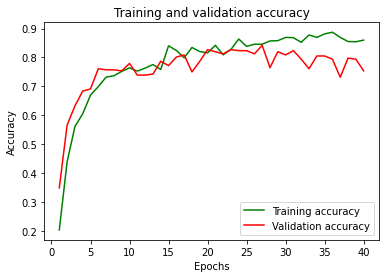

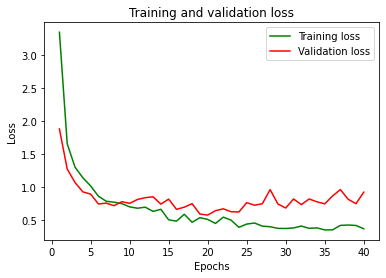

In [124]:
# extracting the records from the history variable for plotting
accuracy = history.history["accuracy"]
val_acc = history.history['val_accuracy']
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(accuracy)+1)

plt.title("Training and validation accuracy")
plt.plot(epochs, accuracy, "green", label = "Training accuracy")
plt.plot(epochs, val_acc, "red", label = "Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.title("Training and validation loss")
plt.plot(epochs, loss, "green", label = "Training loss")
plt.plot(epochs, val_loss, "red", label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()



In [125]:
score = model_vgg16.evaluate(val_data, verbose=1)
print(score)
print('\nKeras CNN - accuracy:', score[1], '\n')

9/9 [==============================] - 6s 709ms/step - loss: 0.9244 - accuracy: 0.7537
[0.9243667721748352, 0.7536764740943909]

Keras CNN - accuracy: 0.7536764740943909 



In [126]:
y_pred_vgg16 = model_vgg16.predict(val_data)
y_pred_vgg16 = np.argmax(y_pred_vgg16 , axis = 1)
print(y_pred_vgg16)

[7 8 3 5 8 3 3 2 6 7 8 3 6 3 0 9 3 7 2 0 0 8 2 7 0 0 1 1 0 7 4 5 6 0 0 7 3
 1 1 6 5 2 0 2 8 8 7 4 1 2 0 2 2 2 7 0 8 6 0 8 0 4 4 7 2 7 7 3 6 4 0 8 9 8
 6 7 0 3 7 1 2 3 1 6 3 7 5 3 3 4 7 3 1 7 4 8 6 4 4 0 4 0 4 3 8 5 1 0 0 8 4
 7 0 0 0 2 8 6 3 7 3 8 8 3 2 3 2 4 6 1 0 1 7 6 5 6 0 7 7 2 1 7 0 7 8 8 0 4
 4 8 8 8 7 2 3 5 2 8 0 7 9 7 7 3 5 0 7 8 0 0 3 3 7 4 0 0 3 3 1 4 8 1 0 3 6
 7 4 3 7 0 9 7 6 2 7 5 7 4 3 4 4 0 5 1 2 8 4 2 7 7 7 0 7 9 0 0 0 6 7 3 8 0
 0 7 3 3 8 0 4 7 2 3 0 6 1 6 0 2 2 1 2 4 4 0 6 6 6 8 9 0 3 7 6 8 3 7 4 3 6
 6 4 0 0 5 0 5 1 0 2 1 9 7]


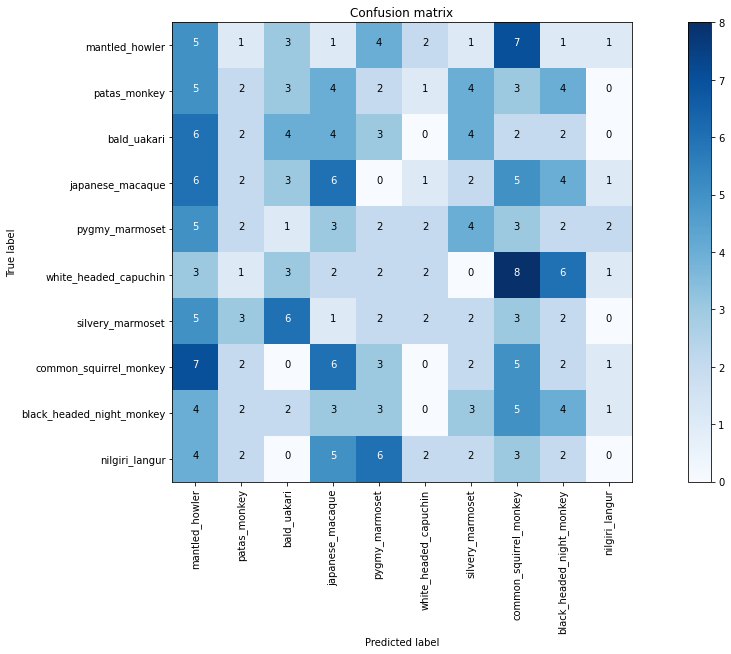

In [128]:
confusion_mtx = confusion_matrix(y_test, y_pred_vgg16)
plot_confusion_matrix(confusion_mtx, classes = labels)
plt.show()

In [129]:
model_vgg16.save("/content/drive/My Drive/Monkey classfier/model_vgg16.h5")

# VGGNet19

Similarly I will train data by VGGNet19 Architecture

The difference is only that in vgg19 there are 19 layers and in vgg16 there are 16 layers

In [130]:
model_vgg19 = VGG19(input_shape = Img_Size + [3], weights = "imagenet", include_top = False)

for layer in model_vgg19.layers:
  layer.trainable = False

last_layer = model_vgg19.get_layer('block5_pool').output
f= Flatten(name='flatten')(last_layer) # flatten the output of the pooling layer and pass it to the next FC layer
f = Dense(512, activation='relu', name='fc1')(f) # fc1
f = Dense(512, activation='relu', name='fc2')(f) # fc2
out = Dense(units=10, activation='softmax', name='output')(f) # softamx output

vgg19_model = Model(inputs = model_vgg19.input , outputs = out)
vgg19_model.summary()

vgg19_model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

t = time.time()
history = vgg19_model.fit_generator(
    generator = train_data,
    epochs = 40,
    validation_data = val_data)
print("Training time: %s min" %((time.time()-t)/60))

80142336/80134624 [==============================] - 0s 0us/step
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

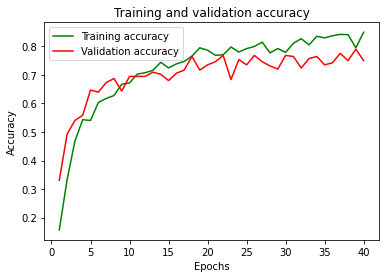

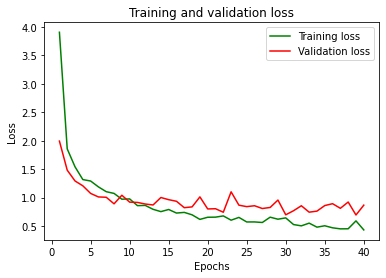

In [131]:
accuracy = history.history["accuracy"]
val_acc = history.history['val_accuracy']
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(accuracy)+1)

plt.title("Training and validation accuracy")
plt.plot(epochs, accuracy, "green", label = "Training accuracy")
plt.plot(epochs, val_acc, "red", label = "Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.title("Training and validation loss")
plt.plot(epochs, loss, "green", label = "Training loss")
plt.plot(epochs, val_loss, "red", label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [132]:
score = vgg19_model.evaluate(val_data, verbose=1)
print(score)
print('\nKeras CNN - accuracy:', score[1], '\n')

9/9 [==============================] - 6s 707ms/step - loss: 0.8680 - accuracy: 0.7500
[0.8679545521736145, 0.75]

Keras CNN - accuracy: 0.75 



In [133]:
y_pred_vgg19 = vgg19_model.predict(val_data)
y_pred_vgg19 = np.argmax(y_pred_vgg19 , axis = 1)
print(y_pred_vgg19)

[1 7 1 1 3 5 0 1 7 9 6 0 7 1 6 7 5 5 2 4 4 1 1 4 6 4 6 4 4 8 7 4 0 6 1 1 6
 3 1 3 1 6 8 7 2 5 1 7 0 3 7 9 3 1 9 6 6 2 6 6 1 8 9 9 3 7 3 7 2 0 6 8 9 6
 4 9 4 1 7 1 8 1 2 7 9 9 6 0 7 6 8 9 3 2 2 9 7 9 2 9 1 6 1 0 2 1 4 4 3 2 0
 9 7 1 8 2 0 8 3 9 9 2 0 5 1 4 2 7 8 9 0 7 1 6 1 9 6 6 9 3 0 1 1 7 9 4 2 3
 7 0 3 6 2 8 5 7 3 7 8 2 6 7 9 1 8 3 8 6 2 7 6 0 3 4 8 5 3 2 6 2 1 8 9 1 8
 8 0 2 4 4 6 8 2 1 8 3 3 7 1 2 8 2 1 0 2 1 0 9 9 9 7 3 9 6 1 1 1 7 1 3 2 8
 8 3 7 9 3 2 4 6 1 7 6 0 1 9 3 7 6 4 6 0 8 3 3 6 3 0 7 3 7 1 2 2 1 1 2 3 6
 8 0 2 7 1 6 4 3 7 9 1 6 6]


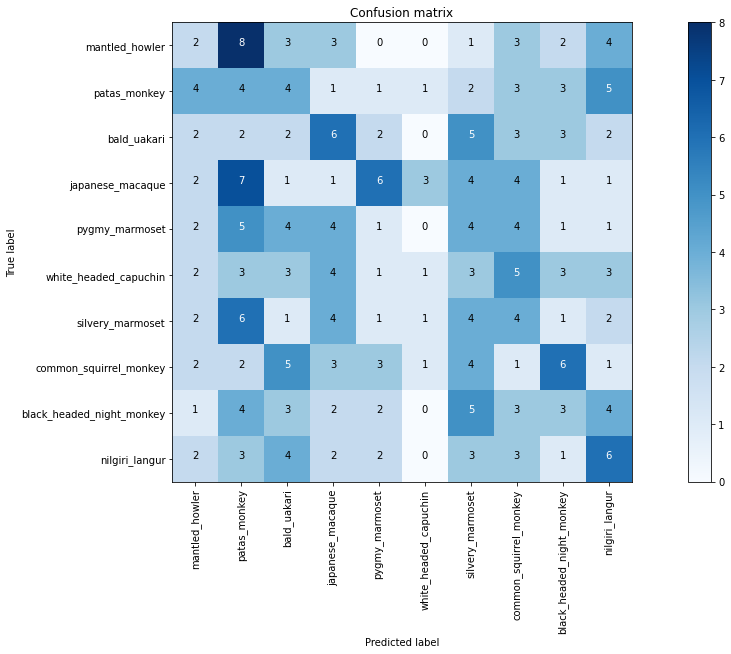

In [135]:
confusion_mtx = confusion_matrix(y_test, y_pred_vgg19)
plot_confusion_matrix(confusion_mtx, classes = labels)
plt.show()

In [136]:
vgg19_model.save("/content/drive/My Drive/Monkey classfier/model_vgg19.h5")

# InceptionV3

In [137]:
model_inc = InceptionV3(input_shape = Img_Size + [3], weights = "imagenet", include_top = False)
for layer in model_inc.layers:
  layer.trainable = False

z = Flatten()(model_inc.output) # flatten the output of the last layer and pass it to the next  layer
prediction = Dense(len(folder_train), activation = "softmax")(z)  # length(folder_train = 10(classes)) Joining the Faltten layer with softmax layer
inception_model = Model(inputs = model_inc.input , outputs = prediction)

inception_model.summary()

inception_model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

t = time.time()
history = inception_model.fit_generator(
    generator = train_data,
    epochs = 40,
    validation_data = val_data)
print("Training time: %s min" %((time.time()-t)/60))

87916544/87910968 [==============================] - 1s 0us/step
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

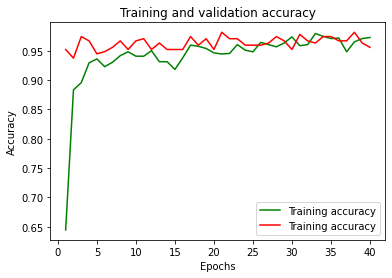

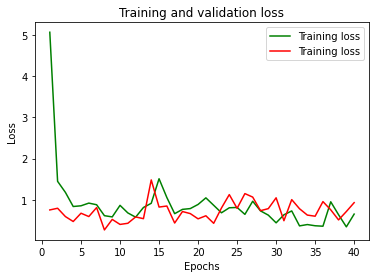

In [138]:
accuracy = history.history["accuracy"]
val_acc = history.history['val_accuracy']
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(accuracy)+1)

plt.title("Training and validation accuracy")
plt.plot(epochs, accuracy, "green", label = "Training accuracy")
plt.plot(epochs, val_acc, "red", label = "Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.title("Training and validation loss")
plt.plot(epochs, loss, "green", label = "Training loss")
plt.plot(epochs, val_loss, "red", label = "Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [141]:
# y_pred_inception will gives the probability of each class. And those who have highest probability is the predicted class
y_pred_inception = inception_model.predict(val_data)
y_pred_inception = np.argmax(y_pred_inception , axis = 1)
print(y_pred_inception)

[7 4 3 6 8 8 8 8 7 7 1 1 3 3 3 5 4 2 4 0 6 2 1 3 2 5 3 9 6 4 1 3 1 5 0 5 5
 0 1 5 2 1 6 0 5 5 7 0 8 7 1 0 8 8 5 3 8 0 5 6 2 4 4 9 8 9 9 3 5 9 3 7 7 3
 1 0 0 5 1 9 9 8 9 8 6 0 3 7 3 6 7 4 5 5 9 1 9 1 0 4 8 5 6 7 7 3 6 6 5 6 2
 4 1 6 0 8 5 6 4 8 2 4 3 0 5 6 3 2 5 5 0 3 0 0 9 1 5 2 9 3 5 5 1 6 2 9 1 7
 2 0 1 2 0 1 2 0 4 8 8 3 6 1 7 6 0 1 4 8 2 8 4 9 2 8 8 0 7 9 5 7 2 9 1 4 7
 6 5 3 2 7 3 1 5 6 1 0 1 3 0 3 9 6 2 0 3 8 0 3 0 9 3 1 9 2 1 8 4 7 9 2 4 0
 9 2 5 8 4 6 3 2 9 4 1 6 6 4 2 6 8 4 2 8 8 8 4 4 6 2 6 7 0 4 7 3 2 8 9 9 1
 9 3 8 7 2 4 9 7 1 2 1 1 3]


In [142]:
score = inception_model.evaluate(val_data, verbose=1)
print(score)
print('\nKeras CNN - accuracy:', score[1], '\n')

9/9 [==============================] - 7s 774ms/step - loss: 0.9309 - accuracy: 0.9559
[0.930912435054779, 0.9558823704719543]

Keras CNN - accuracy: 0.9558823704719543 



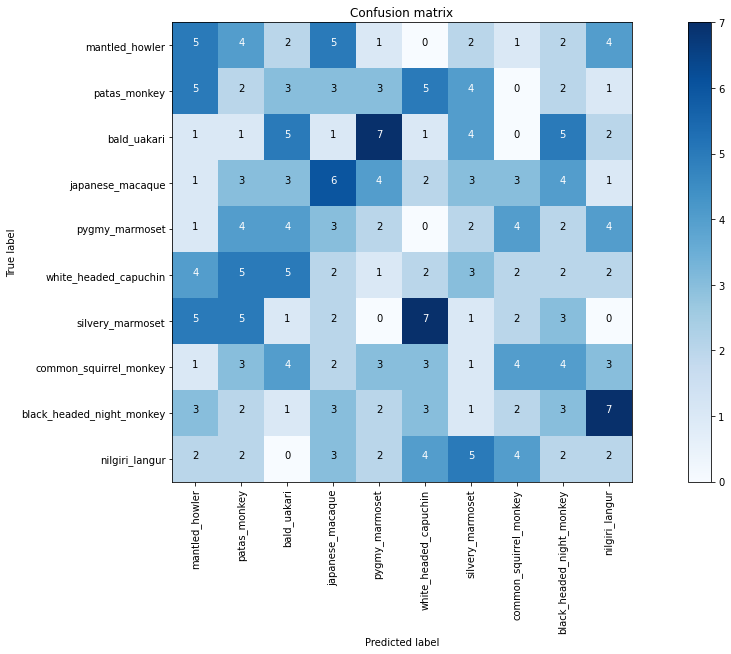

In [144]:
confusion_mtx = confusion_matrix(y_test, y_pred_inception)
plot_confusion_matrix(confusion_mtx, classes = labels)
plt.show()

In [145]:
inception_model.save("/content/drive/My Drive/Monkey classfier/model_inception.h5")  #saving the model

# At last we will use the inception model for further prediction

#Checking the results on unseen image using InceptionV3 Model

In [146]:
#Loading our inception model which is saved in my google drive
model = load_model("/content/drive/My Drive/Monkey classfier/model_inception.h5")

In [153]:
#To check results we will now give image to our model
img = load_img("/content/drive/My Drive/Monkey classfier/test data/n0021.jpg", target_size = (224,224))
x = img_to_array(img)
print(x)

[[[104. 137.  58.]
  [105. 133.  48.]
  [ 97. 131.  45.]
  ...
  [173. 192. 199.]
  [154. 175. 168.]
  [151. 167. 140.]]

 [[111. 144.  65.]
  [109. 144.  64.]
  [110. 139.  57.]
  ...
  [182. 194. 206.]
  [167. 183. 182.]
  [149. 164. 135.]]

 [[108. 150.  68.]
  [124. 158.  71.]
  [122. 155.  64.]
  ...
  [196. 204. 223.]
  [178. 188. 197.]
  [141. 150. 129.]]

 ...

 [[  4.   6.   5.]
  [  6.  10.  11.]
  [ 15.  20.  14.]
  ...
  [106. 110.  87.]
  [ 94. 101.  70.]
  [ 76.  87.  44.]]

 [[ 10.  14.  13.]
  [  0.   2.   0.]
  [ 14.  20.  18.]
  ...
  [113. 117.  90.]
  [ 94. 100.  64.]
  [ 89.  96.  54.]]

 [[ 15.  19.  18.]
  [  2.   3.   7.]
  [  0.   2.   1.]
  ...
  [102. 106.  69.]
  [104. 110.  74.]
  [ 89.  95.  59.]]]


In [154]:
x.shape

(224, 224, 3)

In [155]:
#Normalizing my input image since we had trained your model after normalizing the training images.
x = x/255.0
print(x)

[[[0.40784314 0.5372549  0.22745098]
  [0.4117647  0.52156866 0.1882353 ]
  [0.38039216 0.5137255  0.1764706 ]
  ...
  [0.6784314  0.7529412  0.78039217]
  [0.6039216  0.6862745  0.65882355]
  [0.5921569  0.654902   0.54901963]]

 [[0.43529412 0.5647059  0.25490198]
  [0.42745098 0.5647059  0.2509804 ]
  [0.43137255 0.54509807 0.22352941]
  ...
  [0.7137255  0.7607843  0.80784315]
  [0.654902   0.7176471  0.7137255 ]
  [0.58431375 0.6431373  0.5294118 ]]

 [[0.42352942 0.5882353  0.26666668]
  [0.4862745  0.61960787 0.2784314 ]
  [0.47843137 0.60784316 0.2509804 ]
  ...
  [0.76862746 0.8        0.8745098 ]
  [0.69803923 0.7372549  0.77254903]
  [0.5529412  0.5882353  0.5058824 ]]

 ...

 [[0.01568628 0.02352941 0.01960784]
  [0.02352941 0.03921569 0.04313726]
  [0.05882353 0.07843138 0.05490196]
  ...
  [0.41568628 0.43137255 0.34117648]
  [0.36862746 0.39607844 0.27450982]
  [0.29803923 0.34117648 0.17254902]]

 [[0.03921569 0.05490196 0.05098039]
  [0.         0.00784314 0.        ]


In [156]:
x= np.expand_dims(x,axis=0)
img_data = preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [157]:
model.predict(img_data)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [158]:
a = np.argmax(model.predict(img_data),axis = 1)
print(a)

[0]


In [161]:
if a==0:
  print("mantled Howler")
elif a == 1:
  print("patas_monkey")
elif a == 2:
  print("Bald Uakari")
elif a == 3:
  print("Japanese Macque")
elif a == 4:
  print("Pygmy Marmoset")
elif a == 5:
  print("White headed Capuchin")
elif a == 6:
  print("Silvery Marmoset")
elif a == 7:
  print("Common Squirrel Monkey")
elif a == 8:
  print("Black Headed Night Monkey")
elif a == 9:
  print("Nilgiri Langur")



mantled Howler


#I have made flask webapp of this project.
#If you want to see then go through heet.py file i have provided